In [2]:
import numpy as np
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rijulshr/pneumoniamnist")

print("Path to dataset files:", path)
data = np.load(f"{path}/pneumoniamnist.npz")

xtrain = data['train_images']

ytrain = data['train_labels']
xvalid = data['val_images']
yvalid = data['val_labels']
xtest = data['test_images']
ytest = data['test_labels']

Path to dataset files: /kaggle/input/pneumoniamnist


In [3]:
import shutil
shutil.copytree(path, "/content/pneumonia_data", dirs_exist_ok=True)

'/content/pneumonia_data'

['train_images', 'train_labels', 'val_images', 'val_labels', 'test_images', 'test_labels']


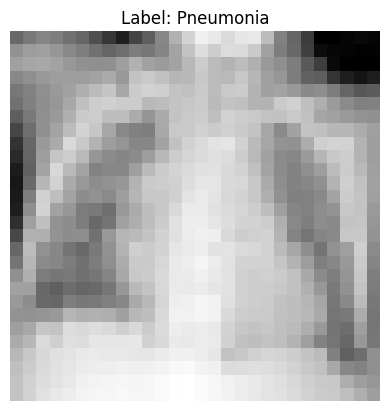

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Check what arrays are inside
print(data.files)  # e.g., ['xtrain', 'ytrain', 'xtest', 'ytest']

# Visualize the first image in the training set
img = xtrain[0]
label =ytrain[0]

plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"Label: {'Pneumonia' if label == 1 else 'Normal'}")
plt.axis('off')
plt.show()


In [5]:
print("xtrain shape:", xtrain.shape)
print("ytrain shape:", ytrain.shape)
print("xvalid shape:", xvalid.shape)
print("yvalid shape:", yvalid.shape)
print("xtest shape:", xtest.shape)
print("ytest shape:", ytest.shape)

# Check label dimensions
print("\nIs ytrain 1D? ", ytrain.ndim == 1)
print("ytrain ndim:", ytrain.ndim)
print("First 10 ytrain labels:", ytrain[:10].reshape(-1))

xtrain shape: (3882, 28, 28)
ytrain shape: (3882, 1)
xvalid shape: (524, 28, 28)
yvalid shape: (524, 1)
xtest shape: (624, 28, 28)
ytest shape: (624, 1)

Is ytrain 1D?  False
ytrain ndim: 2
First 10 ytrain labels: [1 1 1 1 1 1 1 1 1 1]


Train Class Distribution:
Class 0: 388 samples
Class 1: 3494 samples

Validation Class Distribution:
Class 0: 135 samples
Class 1: 389 samples

Test Class Distribution:
Class 0: 234 samples
Class 1: 390 samples


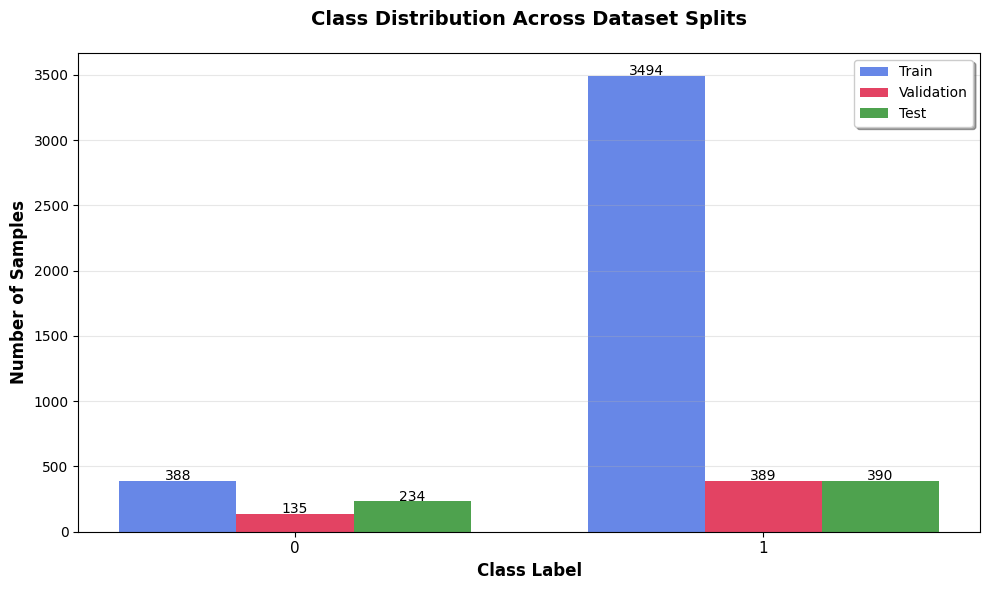

In [6]:
import matplotlib.pyplot as plt
unique_train, counts_train = np.unique(ytrain, return_counts=True)
unique_val, counts_val = np.unique(yvalid, return_counts=True)
unique_test, counts_test = np.unique(ytest, return_counts=True)

# Print distribution
print("Train Class Distribution:")
for cls, count in zip(unique_train, counts_train):
    print(f"Class {cls}: {count} samples")

print("\nValidation Class Distribution:")
for cls, count in zip(unique_val, counts_val):
    print(f"Class {cls}: {count} samples")

print("\nTest Class Distribution:")
for cls, count in zip(unique_test, counts_test):
    print(f"Class {cls}: {count} samples")

#  visualize imbalance
plt.figure(figsize=(10, 6))
bar_width = 0.25
x_pos = np.arange(len(unique_train))

plt.bar(x_pos - bar_width, counts_train, width=bar_width, color='royalblue', alpha=0.8, label='Train')
plt.bar(x_pos, counts_val, width=bar_width, color='crimson', alpha=0.8, label='Validation')
plt.bar(x_pos + bar_width, counts_test, width=bar_width, color='forestgreen', alpha=0.8, label='Test')

plt.xlabel("Class Label", fontsize=12, fontweight='bold')
plt.ylabel("Number of Samples", fontsize=12, fontweight='bold')
plt.xticks(x_pos, unique_train, fontsize=11)
plt.title("Class Distribution Across Dataset Splits", fontsize=14, pad=20, fontweight='bold')

# Add value labels on top of bars
for i, v in enumerate(counts_train):
    plt.text(i - bar_width, v + 5, str(v), color='black', ha='center')
for i, v in enumerate(counts_val):
    plt.text(i, v + 5, str(v), color='black', ha='center')
for i, v in enumerate(counts_test):
    plt.text(i + bar_width, v + 5, str(v), color='black', ha='center')

plt.legend(framealpha=1, shadow=True)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [7]:
import numpy as np
import cv2
from tensorflow.keras.applications.inception_v3 import preprocess_input

def preprocess(images):
    processed = []
    for img in images:
        # Ensure image is 2D (28x28)
        if img.ndim == 3 and img.shape[-1] == 1:
            img = img.squeeze(-1)
        # Convert grayscale to RGB by stacking
        img_rgb = np.stack([img]*3, axis=-1)
        # Resize to 299x299
        img_resized = cv2.resize(img_rgb, (299, 299), interpolation=cv2.INTER_LINEAR)
        processed.append(img_resized)
    processed = np.array(processed, dtype=np.float32)
    # Preprocess for InceptionV3
    processed = preprocess_input(processed)
    return processed

# Apply to your datasets
xtrain = preprocess(xtrain)
xvalid = preprocess(xvalid)
xtest= preprocess(xtest)


In [8]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence

class MinorityAugmentSequence(Sequence):
    def __init__(self, x, y, batch_size, minority_class=0, augment_params=None):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.minority_class = minority_class
        self.augmentor = ImageDataGenerator(**(augment_params or {}))

        # Split indices
        self.min_idx = np.where(y == minority_class)[0]
        self.maj_idx = np.where(y != minority_class)[0]

        # Compute how many times to repeat minority samples to balance
        self.n_maj = len(self.maj_idx)
        self.n_min = len(self.min_idx)
        self.n_batches = int(np.ceil(2 * self.n_maj / batch_size))

    def __len__(self):
        return self.n_batches

    def __getitem__(self, idx):
        # Number of minority and majority samples per batch (try to balance)
        half_bs = self.batch_size // 2

        maj_indices = np.random.choice(self.maj_idx, half_bs, replace=False)
        min_indices = np.random.choice(self.min_idx, self.batch_size - half_bs, replace=True)

        x_maj = self.x[maj_indices]
        y_maj = self.y[maj_indices]

        x_min = self.x[min_indices]
        y_min = self.y[min_indices]

        # Augment only minority samples
        x_min_aug = np.empty_like(x_min)
        for i in range(len(x_min)):
            x_min_aug[i] = self.augmentor.random_transform(x_min[i])

        # Combine and shuffle
        x_batch = np.concatenate([x_maj, x_min_aug], axis=0)
        y_batch = np.concatenate([y_maj, y_min], axis=0)
        indices = np.arange(self.batch_size)
        np.random.shuffle(indices)
        return x_batch[indices], y_batch[indices]


augment_params = dict(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

batch_size = 32
train_generator = MinorityAugmentSequence(
    xtrain, ytrain, batch_size=batch_size,
    minority_class=0, augment_params=augment_params
)


from tensorflow.keras.preprocessing.image import ImageDataGenerator

valid_datagen = ImageDataGenerator()
valid_generator = valid_datagen.flow(
    xvalid, yvalid,
    batch_size=batch_size,
    shuffle=False
)


In [9]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# 1. Load InceptionV3 base model (pretrained on ImageNet, exclude top)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# 2. Freeze all layers except the top few for fine-tuning
for layer in base_model.layers[:-30]:
    layer.trainable = False

# 3. Add custom head for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

# 4. Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 5. Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]


# Ensure ytrain is a 1D NumPy array of class labels
ytrain = np.array(ytrain).ravel()

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(ytrain),
    y=ytrain
)

# Map class weights to dictionary (class label: weight)
class_weight_dict = {
    label: weight for label, weight in zip(np.unique(ytrain), class_weights)
}

# 7. Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=valid_generator,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

# 8. Evaluate model on test set
# Predict probabilities
y_pred_prob = model.predict(xtest)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Metrics
print("Test Accuracy:", accuracy_score(ytest, y_pred))
print("Test F1 Score:", f1_score(ytest, y_pred))
print("Test ROC AUC:", roc_auc_score(ytest, y_pred_prob))
print("\nClassification Report:\n", classification_report(ytest, y_pred, digits=4))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 126s 462ms/step - accuracy: 0.9086 - loss: 0.4329 - val_accuracy: 0.9237 - val_loss: 0.1829 - learning_rate: 1.0000e-04
Epoch 2/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 93s 425ms/step - accuracy: 0.9753 - loss: 0.0576 - val_accuracy: 0.9275 - val_loss: 0.1686 - learning_rate: 1.0000e-04
Epoch 3/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 95s 434ms/step - accuracy: 0.9842 - loss: 0.0434 - val_accuracy: 0.9389 - val_loss: 0.1484 - learning_rate: 1.0000e-04
Epoch 4/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 93s 423ms/step - accuracy: 0.9945 - loss: 0.0238 - val_accuracy: 0.9427 - val_loss: 0.1276 - learning_rate: 1.0000e-04
Epoch 5/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 92s 418ms/step - accuracy: 0.9951 - loss: 0.0138 - val_accuracy: 0.9370 - val_loss: 0.1572 - learning_rate: 1.0000e-04
Epoch 6/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 93s 425ms/step - accuracy: 0.9969 - loss: 0.0106 - val_accuracy: 0.9485 - val_loss: 0.1349 - learning_rate: 1.0000e-04
Epoch 7/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 94s 4

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


True label: Pneumonia
Predicted label: Pneumonia
Predicted probability of pneumonia: 0.8292


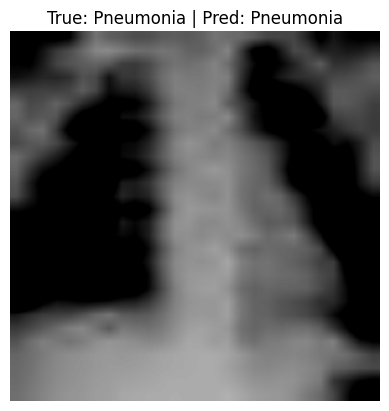

In [10]:
import numpy as np
import matplotlib.pyplot as plt


idx = 567


# 2. Get the original image and label
original_img = xtest[idx]      # shape: (28, 28) grayscale
true_label = ytest[idx]        # 0 for normal, 1 for pneumonia

# 3. Get the preprocessed image
img_input = np.expand_dims(xtest[idx], axis=0)  # Add batch dimension

# 4. Make prediction
pred_prob = model.predict(img_input)[0][0]
pred_label = int(pred_prob > 0.5)

# 5. Print results
print(f"True label: {'Pneumonia' if true_label==1 else 'Normal'}")
print(f"Predicted label: {'Pneumonia' if pred_label==1 else 'Normal'}")
print(f"Predicted probability of pneumonia: {pred_prob:.4f}")

# 6. Visualize the image
plt.imshow(original_img, cmap='gray')
plt.title(f"True: {'Pneumonia' if true_label==1 else 'Normal'} | Pred: {'Pneumonia' if pred_label==1 else 'Normal'}")
plt.axis('off')
plt.show()
